In [174]:
import scanpy as sc
import numpy as np
import torch
import pandas as pd
from model import ZINBVAE
from dataset import base_genes, get_mech_dataset
from training import train
from utils import sample_zinb, plot_column_densities, set_seed, plot_umap_pca
from perturb import produce_perturbed_observations_1gene
import matplotlib.pyplot as plt

In [175]:
n_cells=10000
n_genes=20
target_zero_prob=.8
n_epochs = 1000

In [176]:
x, mu_values, theta_values, pi_values = base_genes(n_cells=n_cells, 
                                                    n_genes=n_genes, 
                                                    target_zero_prob=target_zero_prob, 
                                                    mu_bot=1.0, 
                                                    mu_top=10, 
                                                    theta_bot=0.5, 
                                                    theta_top=2.0,
                                                    seed=42)

Actual overall zero proportion: 0.7997


In [177]:
x, mu_values, theta_values, pi_values, mean_weights, dispersion_weights, n_genes = get_mech_dataset(
                                                                                x=x,
                                                                                mu_values=mu_values,
                                                                                theta_values=theta_values,
                                                                                pi_values=pi_values,
                                                                                n_cells=n_cells,
                                                                                n_genes=n_genes,
                                                                                target_zero_prob=target_zero_prob,
                                                                                seeds=[43,11],
                                                                                theta_fixed=True
                                                                            )

In [178]:
perturbed_samples, perturbed_gene_idx = produce_perturbed_observations_1gene(
        x=x,
        mean_weights=mean_weights,
        n_perturbed_samples=30,
        reference_sample_idx=0,
        suppressing_perturbation=False,
        perturbed_gene_idx=1,
        perturbation_increment=1,
        )

min weight: -1.8839447023025584, max weight: 1.466594563596801
A perturbed_gene_idx was provided. The suppressing_perturbation flag will be ignored.


In [180]:
vae = ZINBVAE(input_dim=x.shape[1], hidden_dim=40, latent_dim=10)
state_dict = torch.load("trained_models/trained_model_state_dict.pth", weights_only=False)
vae.load_state_dict(state_dict)
device = "cuda" if torch.cuda.is_available() else "cpu"
perturbed_samples = torch.tensor(perturbed_samples, dtype=torch.float32)

vae.eval()
set_seed(1)
with torch.no_grad():
    mean, disp, pi, mu, logvar, z = vae(perturbed_samples)

to_numpy = lambda x : x.detach().numpy()

pred_mean, pred_disp, pred_pi, mu, logvar, z, perturbed_samples = [to_numpy(el) for el in [mean, disp, pi, mu, logvar, z, perturbed_samples]]

In [181]:
input_values = perturbed_samples[:,perturbed_gene_idx]
pred_mean_gene = pred_mean[:,perturbed_gene_idx]
true_mean_gene = np.sum(perturbed_samples[:,:-1] * mean_weights, axis=1)
true_mean_gene = np.clip(true_mean_gene, 0.1, None)

Text(0.5, 1.0, 'Out-of-distribution perturbation prediction')

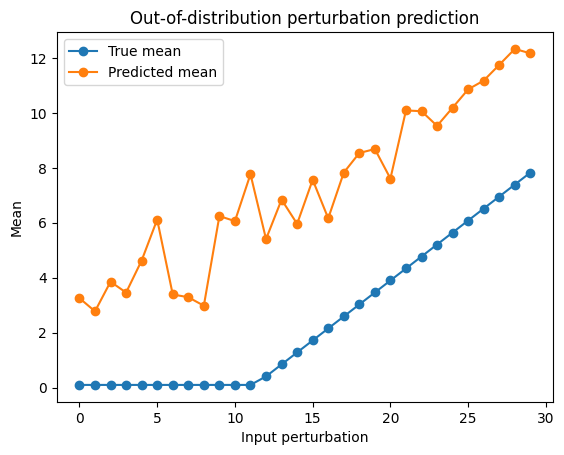

In [186]:
plt.plot(input_values, true_mean_gene, label="True mean", marker="o")
plt.plot(input_values, pred_mean_gene, label="Predicted mean", marker="o")
plt.legend()
plt.xlabel("Input perturbation")
plt.ylabel("Mean")
plt.title("Out-of-distribution perturbation prediction")